In [36]:
#import packages
import pandas as pd
import numpy as np
import random
import re
import string
#import requests
#import plotnine 
#from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

#may need to pip install first
#!pip install netwulf
from netwulf import visualize
import netwulf as nw
import networkx as nx


# Data Prep

## Load in Data

In [37]:
# Define the file path
pre_file_path = '../code/data/Med student pre assessment 2.8.23.csv'
foundational_file_path = '../code/data/Foundational Post Assessment 2.8.23.csv'
intermediate_file_path = '../code/data/intermediate post assessment 2.8.23.csv'
advanced_file_path = '../code/data/Advanced post assessment 2.8.23.csv'

# Load the datasets using pandas
pre_data = pd.read_csv(pre_file_path)
post_data_foundational = pd.read_csv(foundational_file_path,skiprows =lambda x: x in [1,2])
post_data_intermediate = pd.read_csv(intermediate_file_path,skiprows =lambda x: x in [1,2])
post_data_advanced = pd.read_csv(advanced_file_path,skiprows =lambda x: x in [1,2])


## Merge Data

In [38]:
#merge pre to foundational post, where scox = pre score, scoy = post score
joined_data_foundational = pd.merge(post_data_foundational, pre_data, on = "IPAddress", how = "left")
joined_data_intermediate = pd.merge(post_data_intermediate, pre_data, on = "IPAddress", how = "left")
joined_data_advanced = pd.merge(post_data_advanced, pre_data, on = "IPAddress", how = "left")


## Rename columns

In [39]:
#renaming the columns, SC0y = pre, SC0x = post for clarity:
foundational_data = joined_data_foundational.rename(columns={'SC0_y':'Pre', 'SC0_x':'Post'})
#drop missing data from Pre and Post
foundational_data = foundational_data.dropna(subset=['Pre', 'Post'])

#do the same for two other cohorts
intermediate_data = joined_data_intermediate.rename(columns={'SC0_y':'Pre', 'SC0_x':'Post'})
intermediate_data = intermediate_data.dropna(subset=['Pre', 'Post'])

advanced_data = joined_data_advanced.rename(columns={'SC0_y':'Pre', 'SC0_x':'Post'})
advanced_data = advanced_data.dropna(subset=['Pre', 'Post'])

## Data prep for histograms:

In [40]:
#transform to long format 
foundational_plot_data = foundational_data[['Pre', 'Post']].melt().rename(columns={'variable': 'Condition', 'value': "SC0"})
foundational_plot_data['SC0'] = foundational_plot_data['SC0'].astype(int)

#do the same for two other cohorts
intermediate_plot_data = intermediate_data[['Pre', 'Post']].melt().rename(columns={'variable': 'Condition', 'value': "SC0"})
intermediate_plot_data['SC0'] = intermediate_plot_data['SC0'].astype(int)

advanced_plot_data = advanced_data[['Pre', 'Post']].melt().rename(columns={'variable': 'Condition', 'value': "SC0"})
advanced_plot_data['SC0'] = advanced_plot_data['SC0'].astype(int)

## Data prep for Network Visualization:

In [41]:
#add a column called advanced for advanced_df
post_data_advanced['advanced'] = 1
#add a column called intermediate for intermediate_df
post_data_intermediate['intermediate'] = 1
#add a column called foundational for foundational_df
post_data_foundational['foundational'] = 1

In [42]:
#combine all three dataframes
combined_df = pd.concat([post_data_advanced, post_data_intermediate, post_data_foundational], ignore_index=True)

#fill NaN values in the 'advanced', 'intermediate', and 'foundational' columns with 0
combined_df['advanced'] = combined_df['advanced'].fillna(0)
combined_df['intermediate'] = combined_df['intermediate'].fillna(0)
combined_df['foundational'] = combined_df['foundational'].fillna(0)

In [43]:
#assign quartiles to the sc0
combined_df['quartile'] = pd.qcut(combined_df['SC0'], 4, labels=False)

#define the conditions
conditions = [
    combined_df['advanced'] == 1,
    combined_df['intermediate'] == 1,
    combined_df['foundational'] == 1
]

#define the choices corresponding to each condition
choices = ['advanced', 'intermediate', 'foundational']

#create the 'cohort' column using np.select to apply these conditions and choices
combined_df['cohort'] = np.select(conditions, choices, default='unknown')


## Data prep for correlation plot

In [44]:
#select 'Pre' and 'Post' columns and tag each entry with its cohort
advanced_scores = advanced_data[['Pre','Post']].copy()
advanced_scores['Cohort'] = 'Advanced'

intermediate_scores = intermediate_data[['Pre','Post']].copy()
intermediate_scores['Cohort'] = 'Intermediate'

foundational_scores = foundational_data[['Pre','Post']].copy()
foundational_scores['Cohort'] = 'Foundational'
#
#combine the datasets for analysis
all_scores = pd.concat([advanced_scores, intermediate_scores, foundational_scores])
all_scores[['Pre', 'Post']] = all_scores[['Pre', 'Post']].astype(int)

# Analysis

## Paired t-test

In [45]:
#remove any missing values, and convert the data to int
foundational_stat_data=foundational_data[['Pre','Post']].dropna().astype(int)
print('Foundational paired t-test:')
#conduct a paired t-test to determine if the post-training scores are statistically less than the pre-training scores.
#this tests the hypothesis that the training has led to improvement in scores.
print(stats.ttest_rel(foundational_stat_data['Pre'],foundational_stat_data['Post'],alternative='less'))

#repeat for other cohorts
intermediate_stat_data=intermediate_data[['Pre','Post']].dropna().astype(int)
print('Intermediate paired t-test:')
print(stats.ttest_rel(intermediate_stat_data['Pre'],intermediate_stat_data['Post'],alternative='less'))

advanced_stat_data=advanced_data[['Pre','Post']].dropna().astype(int)
print('Advanced paired t-test:')
print(stats.ttest_rel(advanced_stat_data['Pre'],advanced_stat_data['Post'],alternative='less'))


Foundational paired t-test:
TtestResult(statistic=18.459663693401062, pvalue=1.0, df=38)
Intermediate paired t-test:
TtestResult(statistic=10.813765919832317, pvalue=0.9999999986777756, df=18)
Advanced paired t-test:
TtestResult(statistic=-4.091683222828099, pvalue=0.00010399393388526066, df=39)


# Visualization

## Code for foundational histogram

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


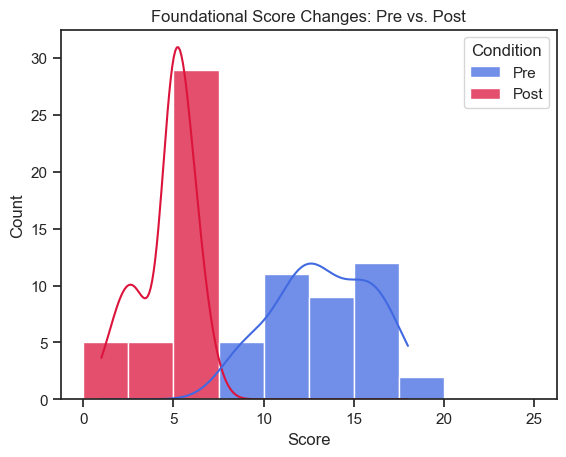

In [46]:
#specifying individual colors for each condition
colors = {"Pre": "royalblue", "Post": "crimson"} 

#create plot
sns.histplot(
    data=foundational_plot_data,
    x='SC0',
    hue='Condition',
    palette=colors,  # Apply the color mapping
    binrange=[0, 25],
    binwidth=2.5,
    alpha=0.75,  # Adjusts opacity
    kde=True 
)

plt.title('Foundational Score Changes: Pre vs. Post')  # Title of the plot
plt.xlabel('Score')  # Label for the x-axis
plt.ylabel('Count')  # Label for the y-axis
sns.set(style="ticks")

plt.show()


## Code for intermediate histogram

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


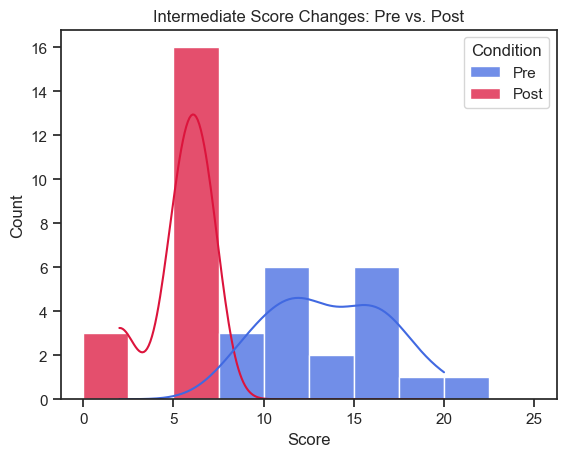

In [47]:
# Plotting
sns.histplot(
    data=intermediate_plot_data,
    x='SC0',
    hue='Condition',
    palette=colors,  # Applying the color mapping
    binrange=[0, 25],
    binwidth=2.5,
    alpha=0.75,  # Adjusting opacity
    kde=True 
)

plt.title('Intermediate Score Changes: Pre vs. Post')  # Updated title for the intermediate cohort
plt.xlabel('Score')  # Label for the x-axis
plt.ylabel('Count')  # Label for the y-axis
sns.set(style="ticks")  # Setting the style to 'ticks' to remove the grid

plt.show()


## Code for advanced histogram

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


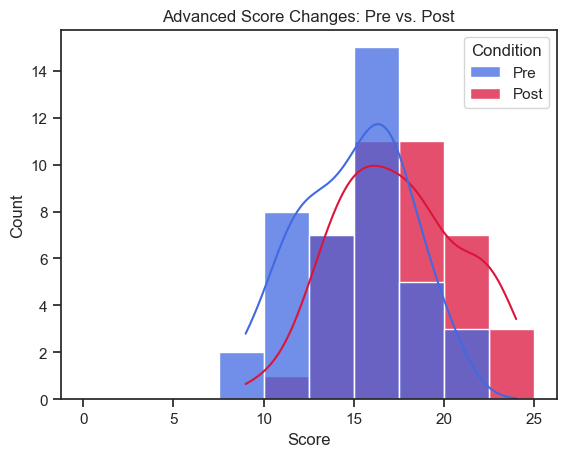

In [48]:
# Specifying individual colors for each condition
colors = {"Pre": "royalblue", "Post": "crimson"}  # Custom colors for the conditions

# Plotting
sns.histplot(
    data=advanced_plot_data,
    x='SC0',
    hue='Condition',
    palette=colors,  # Applying the color mapping
    binrange=[0, 25],
    binwidth=2.5,
    alpha=0.75,  # Adjusting opacity
    kde=True 
)

plt.title('Advanced Score Changes: Pre vs. Post')  # Updated title for the advanced cohort
plt.xlabel('Score')  # Label for the x-axis
plt.ylabel('Count')  # Label for the y-axis
sns.set(style="ticks")  # Setting the style to 'ticks' to remove the grid

plt.show()


## Code for Network Visualization

In [49]:
# Creating the graph
G = nx.Graph()
for idx, row in combined_df.iterrows():
    G.add_node(str(idx) + "Q" + str(row['quartile']), quartile=row['quartile'], cohort=row['cohort'])
    for idx1, data1 in G.nodes(data=True):
        for idx2, data2 in G.nodes(data=True):
            if idx1 != idx2 and data1['quartile'] == data2['quartile']:
                G.add_edge(idx1, idx2)

# Assign node colors based on cohort
color_map = {
    'advanced': '#8ac926',
    'intermediate': '#ffca3a',
    'foundational': '#ff595e'
}
nx.set_node_attributes(G, {idx: color_map[data['cohort']] for idx, data in G.nodes(data=True)}, 'color')

#visualize the network
pos = nx.spring_layout(G, k=0.25, iterations=20)
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, pos, node_color=[data['color'] for _, data in G.nodes(data=True)], with_labels=False, node_size=50, edge_color="grey")

#create a legend for the cohorts
legend_labels = {"Advanced": "#8ac926", "Intermediate": "#ffca3a", "Foundational": "#ff595e"}
for label, color in legend_labels.items():
    plt.scatter([], [], color=color, label=label)

#add labels and titles
plt.title('Network Visualization')
plt.legend(title="Cohort", loc="upper left")
plt.close()


In [50]:
#visualize the network with Netwulf, configuring colors by cohort
stylized_network, config = visualize(G, config={'node_color': 'color'}, port=2000)

## Code for correlation test

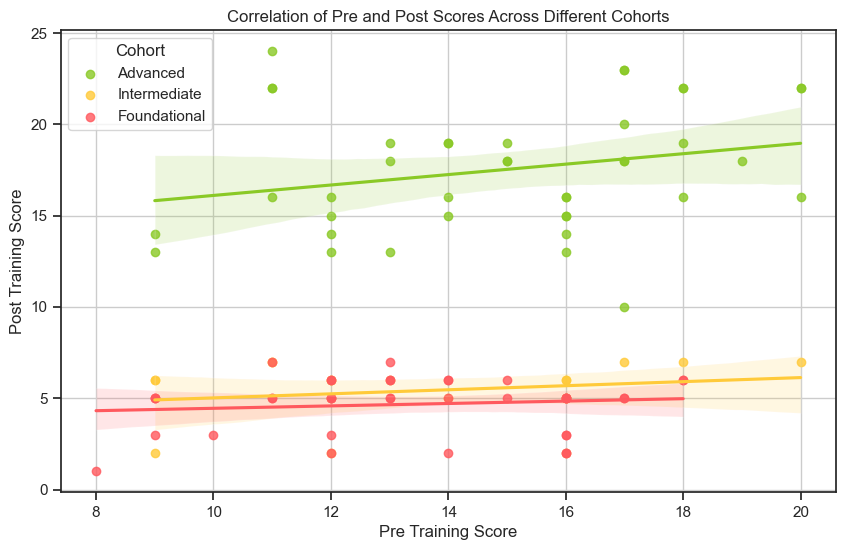

In [51]:
#create a color palette for the cohorts
#got hex codes from coolors
cohort_colors = {
    'Advanced': '#8ac926',  # green
    'Intermediate': '#ffca3a',  # yellow
    'Foundational': '#ff595e'  # red
}

#create regression plots for each cohort with customized colors
plt.figure(figsize=(10, 6))
for cohort, color in cohort_colors.items():
    sns.regplot(data=all_scores[all_scores['Cohort'] == cohort],
                x='Pre', y='Post', color=color, label=cohort)

#add titles and labels
plt.title('Correlation of Pre and Post Scores Across Different Cohorts')
plt.xlabel('Pre Training Score')
plt.ylabel('Post Training Score')
plt.legend(title='Cohort')
plt.grid(True)

## Code For Sentiment Analysis

In [52]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader=SentimentIntensityAnalyzer()

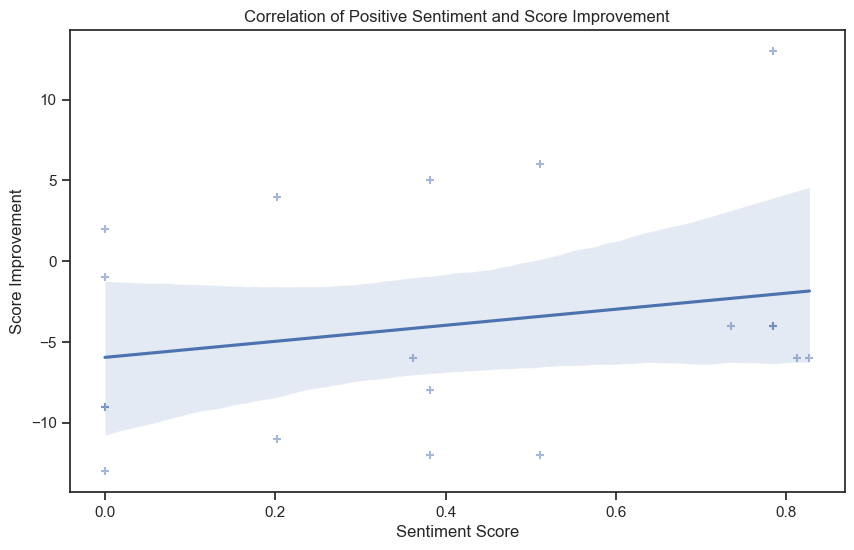

In [53]:
#data loading and preparation
satisfaction_file_path = 'data/module satisfaction evaluations 2.8.23.csv'
satisfaction_df = pd.read_csv(satisfaction_file_path, skiprows=lambda x: x in [1, 2])
satisfaction_df = satisfaction_df[['Q3', 'Q2', 'IPAddress']].rename(columns={'Q3': 'What was most helpful', 'Q2': 'Overall Course Satisfaction'}).dropna()

#merge data
advanced_sat = pd.merge(advanced_data.drop_duplicates(subset=['IPAddress']), satisfaction_df.drop_duplicates(subset=['IPAddress']), on='IPAddress', how='left')
intermediate_sat = pd.merge(intermediate_data.drop_duplicates(subset=['IPAddress']), satisfaction_df.drop_duplicates(subset=['IPAddress']), on='IPAddress', how='left')
foundational_sat = pd.merge(foundational_data.drop_duplicates(subset=['IPAddress']), satisfaction_df.drop_duplicates(subset=['IPAddress']), on='IPAddress', how='left')

#assign cohorts
advanced_sat['Cohort'] = 'advanced'
intermediate_sat['Cohort'] = 'intermediate'
foundational_sat['Cohort'] = 'foundational'
combined_sat = pd.concat([advanced_sat, intermediate_sat, foundational_sat], ignore_index=True)

#sentiment analysis
vader = SentimentIntensityAnalyzer()
combined_sat['sentiment_score'] = [vader.polarity_scores(text)['compound'] if pd.notna(text) else np.nan for text in combined_sat['What was most helpful']]
combined_sat['SC0 Improvement'] = combined_sat['Post'].astype(int) - combined_sat['Pre'].astype(int)

#plotting the regression plot
plt.figure(figsize=(10, 6))
sns.regplot(x='sentiment_score', y='SC0 Improvement', data=combined_sat, fit_reg=True, marker='+', scatter_kws={'alpha':0.5})
plt.title('Correlation of Positive Sentiment and Score Improvement')
plt.xlabel('Sentiment Score')
plt.ylabel('Score Improvement')
#plt.savefig('combined_sentiment_correlation.png')
plt.show()


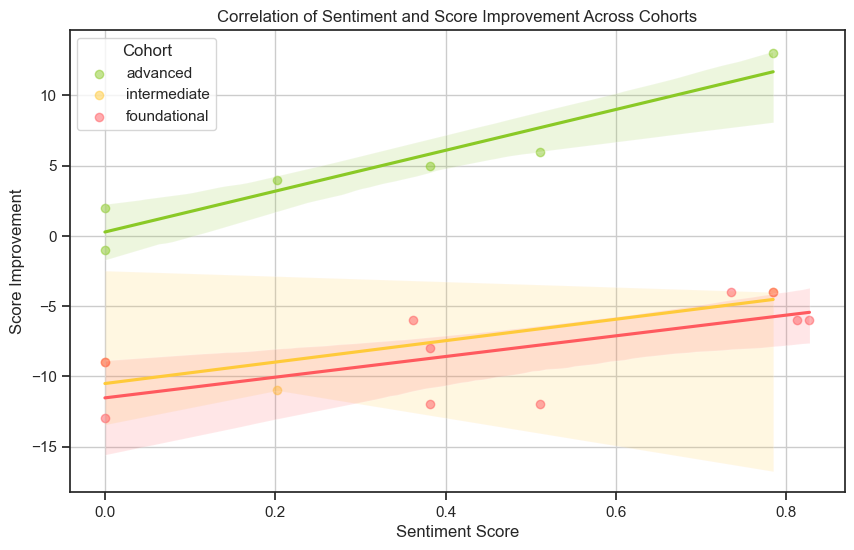

In [54]:
#calculate sentiment scores
combined_sat['sentiment_score'] = [vader.polarity_scores(text)['compound'] if pd.notna(text) else np.nan for text in combined_sat['What was most helpful']]
combined_sat['SC0 Improvement'] = combined_sat['Post'].astype(int) - combined_sat['Pre'].astype(int)

#define cohort colors
cohort_colors = {
    'advanced': '#8ac926',  # green
    'intermediate': '#ffca3a',  # yellow
    'foundational': '#ff595e'  # red
}

#create regression plots for each cohort with customized colors
plt.figure(figsize=(10, 6))
for cohort, color in cohort_colors.items():
    sns.regplot(data=combined_sat[combined_sat['Cohort'] == cohort],
                x='sentiment_score', y='SC0 Improvement', color=color, label=cohort, scatter_kws={'alpha': 0.5})

#add titles and labels
plt.title('Correlation of Sentiment and Score Improvement Across Cohorts')
plt.xlabel('Sentiment Score')
plt.ylabel('Score Improvement')
plt.legend(title='Cohort')
plt.grid(True)
#plt.savefig('cohort_sentiment_regression.png')
plt.show()


## Old sentiment analysis

In [55]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader=SentimentIntensityAnalyzer()#.polarity_scores(["Don't do it"])

In [56]:
satisfaction_file_path = 'data/module satisfaction evaluations 2.8.23.csv'
satisfaction_df=pd.read_csv(satisfaction_file_path,skiprows =lambda x: x in [1,2])

In [57]:
satisfaction_df=satisfaction_df[['Q3','Q2','IPAddress']].rename(columns={'Q3':'What was most helpful','Q2':'Overall Course Satisfaction'}).dropna()

In [58]:
advanced_sat=pd.merge(advanced_data.drop_duplicates(subset=['IPAddress']), satisfaction_df.drop_duplicates(subset=['IPAddress']), on = "IPAddress", how = "left")
intermediate_sat=pd.merge(intermediate_data.drop_duplicates(subset=['IPAddress']), satisfaction_df.drop_duplicates(subset=['IPAddress']), on = "IPAddress", how = "left")
foundational_sat=pd.merge(foundational_data.drop_duplicates(subset=['IPAddress']), satisfaction_df.drop_duplicates(subset=['IPAddress']), on = "IPAddress", how = "left")

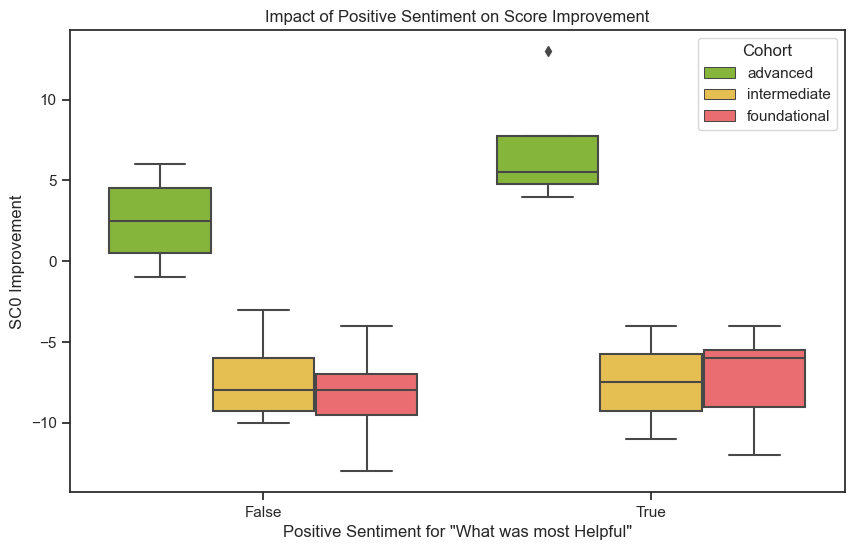

In [59]:
advanced_sat['Cohort']='advanced'
intermediate_sat['Cohort']='intermediate'
foundational_sat['Cohort']='foundational'
combined_sat=pd.concat([advanced_sat,intermediate_sat,foundational_sat],ignore_index=True)

temp= [i if i is not np.NaN else '' for i in combined_sat['What was most helpful']]

#Define the color palette 
palette = {
    'advanced': '#8ac926',  # green
    'intermediate': '#ffca3a',  # yellow
    'foundational': '#ff595e'  # red
}


combined_sat['Positive Sentiment for "What was most Helpful"']=[vader.polarity_scores(i)['compound']>0.05 for i in temp]
combined_sat['SC0 Improvement']=combined_sat['Post'].astype(int)- combined_sat['Pre'].astype(int)

# Use the palette in boxplot for the combined_sat data
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_sat, 
            x='Positive Sentiment for "What was most Helpful"', 
            y='SC0 Improvement', 
            hue='Cohort', 
            palette=palette)
plt.title('Impact of Positive Sentiment on Score Improvement')
plt.show()



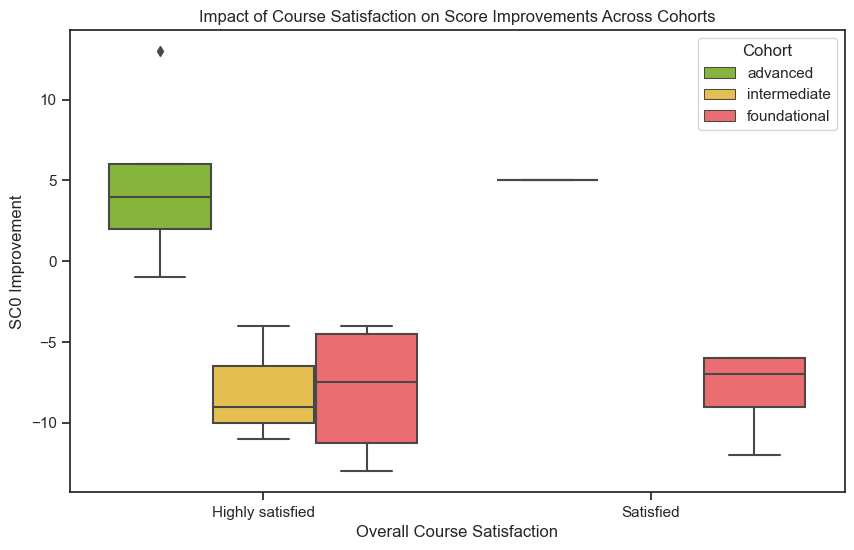

In [60]:
#Define the color palette 
palette = {
    'advanced': '#8ac926',  # green
    'intermediate': '#ffca3a',  # yellow
    'foundational': '#ff595e'  # red
}


plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_sat, 
            x='Overall Course Satisfaction', 
            y='SC0 Improvement', 
            hue='Cohort', 
            palette=palette)
plt.title('Impact of Course Satisfaction on Score Improvements Across Cohorts')
plt.show()


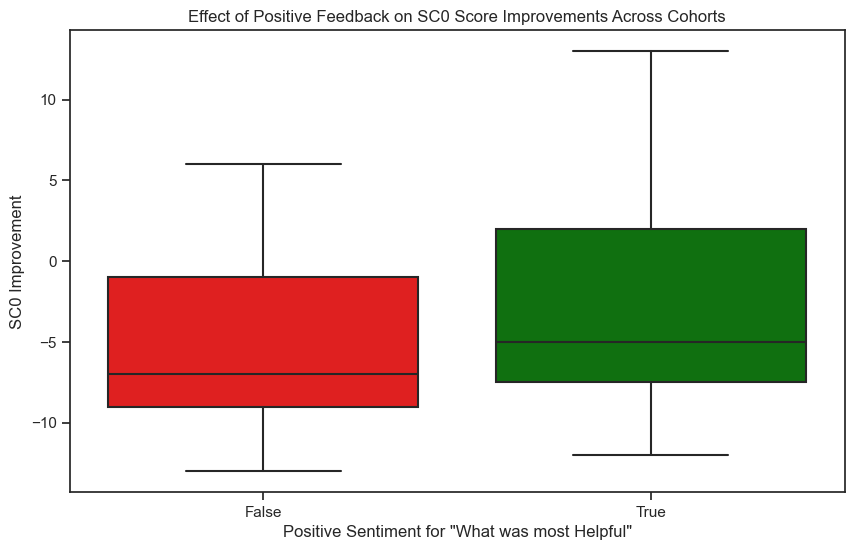

In [61]:
# Define custom color palette
palette = {True: 'green', False: 'red'}

plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_sat, 
            x='Positive Sentiment for "What was most Helpful"', 
            y='SC0 Improvement',
           palette = palette)
plt.title('Effect of Positive Feedback on SC0 Score Improvements Across Cohorts')
plt.show()

## Advanced

These plots show:
- the distribution of SC0 score improvements for those who had positive sentiment in their feedback versus those who did not.
- visualizes how different levels of overall course satisfaction relate to changes in SC0 scores. 

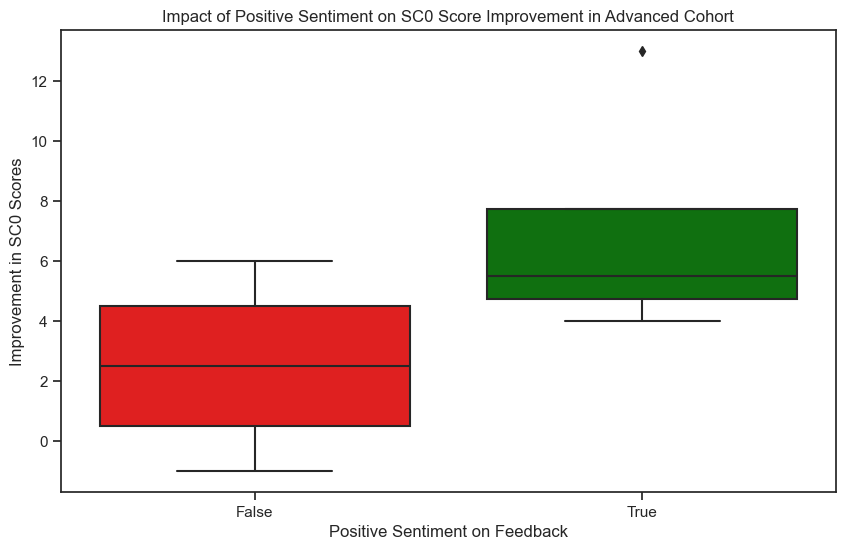

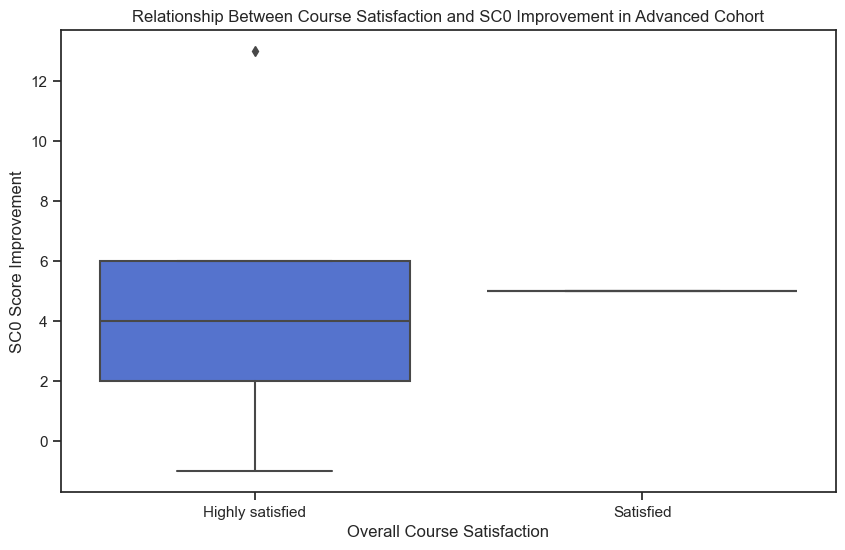

In [62]:
temp= [i if i is not np.NaN else '' for i in advanced_sat['What was most helpful']]
advanced_sat['Positive Sentiment for "What was most Helpful"']=[vader.polarity_scores(i)['compound']>0.05 for i in temp]
advanced_sat['SC0 Improvement']=advanced_sat['Post'].astype(int)- advanced_sat['Pre'].astype(int)

# Define custom color palette
palette = {True: 'green', False: 'red'}
colors = {'Highly satisfied': "royalblue", 'Satisfied': "crimson"}  # Choose any matplotlib compatible colors


# Plot for "Positive Sentiment for 'What was most Helpful'"
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=advanced_sat, 
    x='Positive Sentiment for "What was most Helpful"', 
    y='SC0 Improvement',
    palette=palette
)
plt.title('Impact of Positive Sentiment on SC0 Score Improvement in Advanced Cohort')
plt.xlabel('Positive Sentiment on Feedback')
plt.ylabel('Improvement in SC0 Scores')
plt.show()

# Plot for "Overall Course Satisfaction"
# Ensure that 'Overall Course Satisfaction' is processed to be True/False if not already
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=advanced_sat, 
    x='Overall Course Satisfaction',  # This needs to be boolean or categorized suitably for the palette
    y='SC0 Improvement',
    palette = colors
)
plt.title('Relationship Between Course Satisfaction and SC0 Improvement in Advanced Cohort')
plt.xlabel('Overall Course Satisfaction')
plt.ylabel('SC0 Score Improvement')
plt.show()


## Intermediate
These plots show:
- show how positive sentiment in feedback correlates with improvements in SC0 scores among the intermediate cohort.

- examines the relationship between course satisfaction and SC0 score improvements

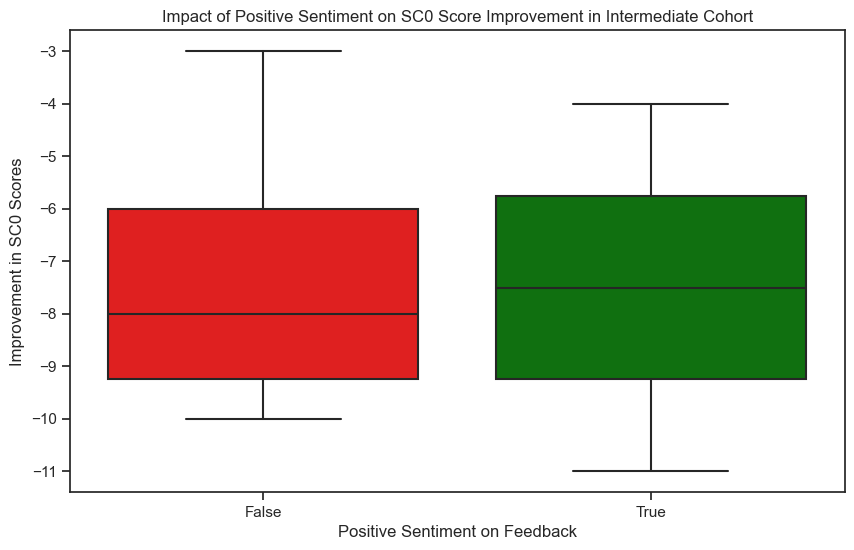

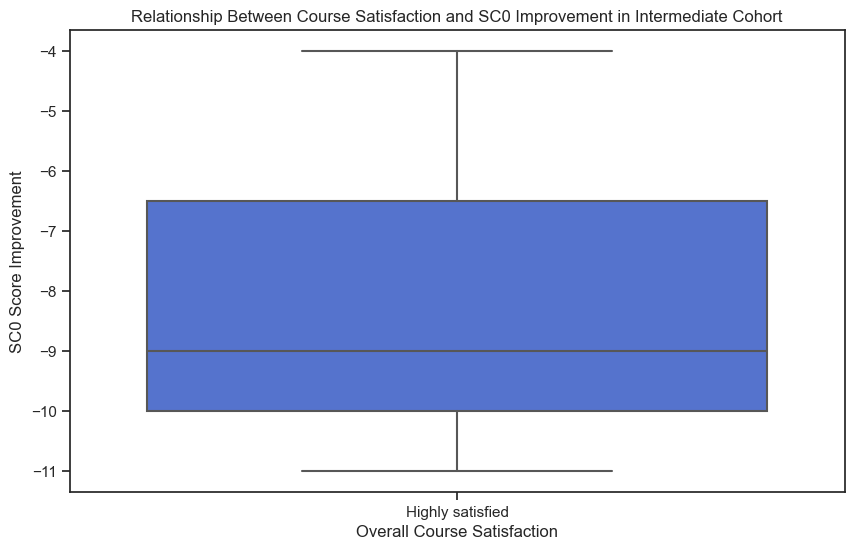

In [63]:
temp= [i if i is not np.NaN else '' for i in intermediate_sat['What was most helpful']]
intermediate_sat['Positive Sentiment for "What was most Helpful"']=[vader.polarity_scores(i)['compound']>0.05 for i in temp]
intermediate_sat['SC0 Improvement']=intermediate_sat['Post'].astype(int)- intermediate_sat['Pre'].astype(int)

# Define custom color palette
palette = {True: 'green', False: 'red'}
colors = {'Highly satisfied': "royalblue", 'Satisfied': "crimson"}  # Choose any matplotlib compatible colors

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=intermediate_sat, 
    x='Positive Sentiment for "What was most Helpful"', 
    y='SC0 Improvement',
    palette=palette
)
plt.title('Impact of Positive Sentiment on SC0 Score Improvement in Intermediate Cohort')
plt.xlabel('Positive Sentiment on Feedback')
plt.ylabel('Improvement in SC0 Scores')
plt.show()



#second plot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=intermediate_sat, 
    x='Overall Course Satisfaction', 
    y='SC0 Improvement',
    palette=colors
)
plt.title('Relationship Between Course Satisfaction and SC0 Improvement in Intermediate Cohort')
plt.xlabel('Overall Course Satisfaction')
plt.ylabel('SC0 Score Improvement')
plt.show()




## Foundational

These plots show:
-a boxplot showing the distribution of SC0 score improvements for those who had positive sentiment in their feedback versus those who did not.

- illustrating how different levels of reported course satisfaction ('Highly satisfied', 'Satisfied', etc.) relate to improvements in SC0 scores post-training.

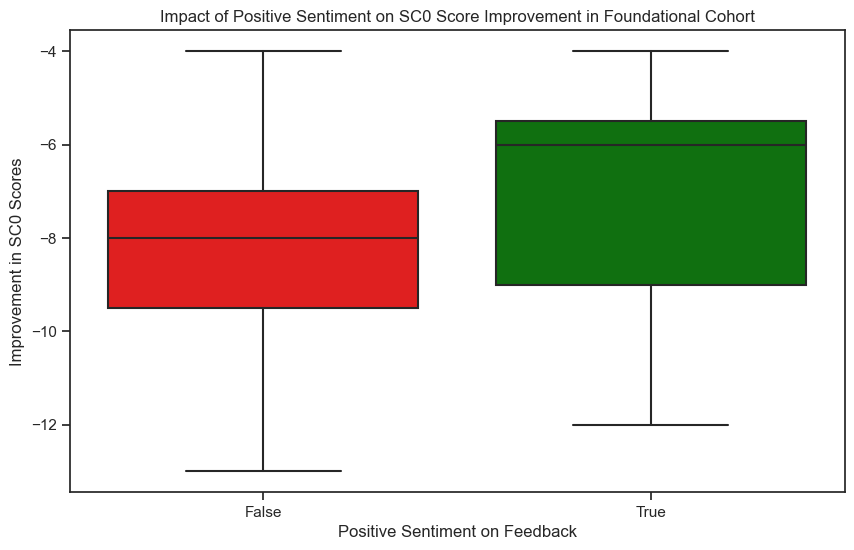

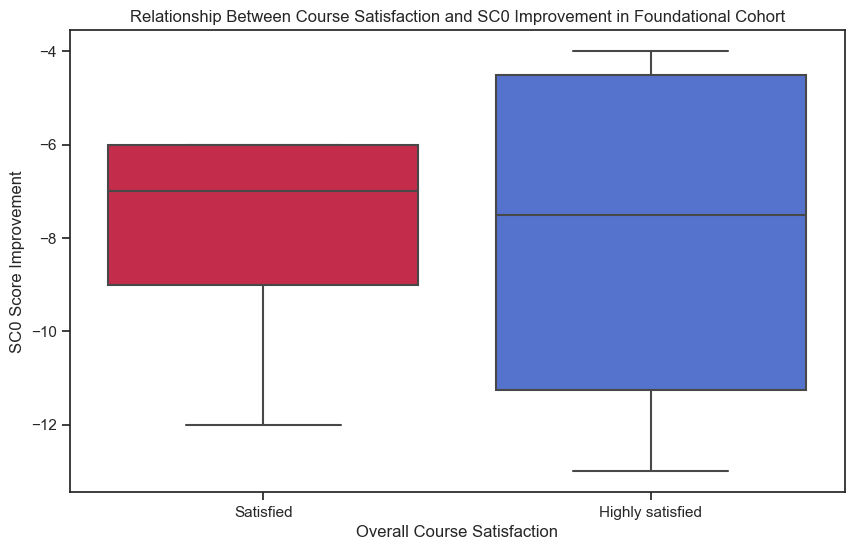

In [64]:
temp= [i if i is not np.NaN else '' for i in foundational_sat['What was most helpful']]
foundational_sat['Positive Sentiment for "What was most Helpful"']=[vader.polarity_scores(i)['compound']>0.05 for i in temp]
foundational_sat['SC0 Improvement']=foundational_sat['Post'].astype(int)- foundational_sat['Pre'].astype(int)

# Define custom color palette
palette = {True: 'green', False: 'red'}
colors = {'Highly satisfied': "royalblue", 'Satisfied': "crimson"}  # Choose any matplotlib compatible colors

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=foundational_sat, 
    x='Positive Sentiment for "What was most Helpful"', 
    y='SC0 Improvement',
    palette=palette
)
plt.title('Impact of Positive Sentiment on SC0 Score Improvement in Foundational Cohort')
plt.xlabel('Positive Sentiment on Feedback')
plt.ylabel('Improvement in SC0 Scores')
plt.show()



#second plot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=foundational_sat, 
    x='Overall Course Satisfaction', 
    y='SC0 Improvement',
    palette=colors
)
plt.title('Relationship Between Course Satisfaction and SC0 Improvement in Foundational Cohort')
plt.xlabel('Overall Course Satisfaction')
plt.ylabel('SC0 Score Improvement')
plt.show()


